In [10]:
import typing
from simulation_env.environment_basic.environment_basic import CropRotationEnv as CropRotationEnv_Basic
from simulation_env.environment_maincrops.environment_maincrops import CropRotationEnv as CropRotationEnv_Advanced
from models.basic.DQN_Prioritized import DeepQAgent as DQN_Prioritized
from models.basic.DQN_Prioritized_Symbolic import DeepQAgent as DQN_Prioritized_Symbolic
from models.advanced.SAC import SACAgent
from models.advanced.SAC_Symbolic import SACAgent as SACAgent_Symbolic
from models.advanced.fake_env import FakeEnv
import numpy as np
from utils.experiment_utils import run_experiment, plot_experiment, plot_losses, plot_losses_sac
import torch
from torch import optim
from itertools import count
import collections
from numpy import random
import typing
import pprint
import optuna
from optuna.trial import TrialState
import math
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
from models.advanced.model_utilities import format_samples_for_training, create_full_replay_buffer, plot_mse_and_kl_losses_per_key
seed = 43
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = CropRotationEnv_Advanced(
    seq_len = 10, 
    seed = seed, 
    DryWetInit = None, 
    GroundTypeInit = None, 
    deterministic = False
    )


random_state = np.random.RandomState(seed)

experience_buffer_size = 500
experience_replay_buffer = create_full_replay_buffer(length = experience_buffer_size, seq_len=10, seed = seed, batch_size = 128, device = device)

test_set_size = 500
test_replay_buffer = create_full_replay_buffer(length = test_set_size, seq_len=10, seed = seed+1, batch_size = 128, device = device)
_, test_experiences = test_replay_buffer.uniform_sample(replace = False,batch_size=test_set_size)
states, actions, rewards, next_states, dones = (torch.stack(vs,0).squeeze(1).to(device) for vs in zip(*test_experiences))
test_inputs, test_outputs = format_samples_for_training(
    states=states, 
    actions = actions, 
    rewards = rewards, 
    next_states = next_states,
    device = device,
    num_actions = env.num_crops,
    )



# Train all models

Model-Utilities: Custom model setting dict loaded
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Epi

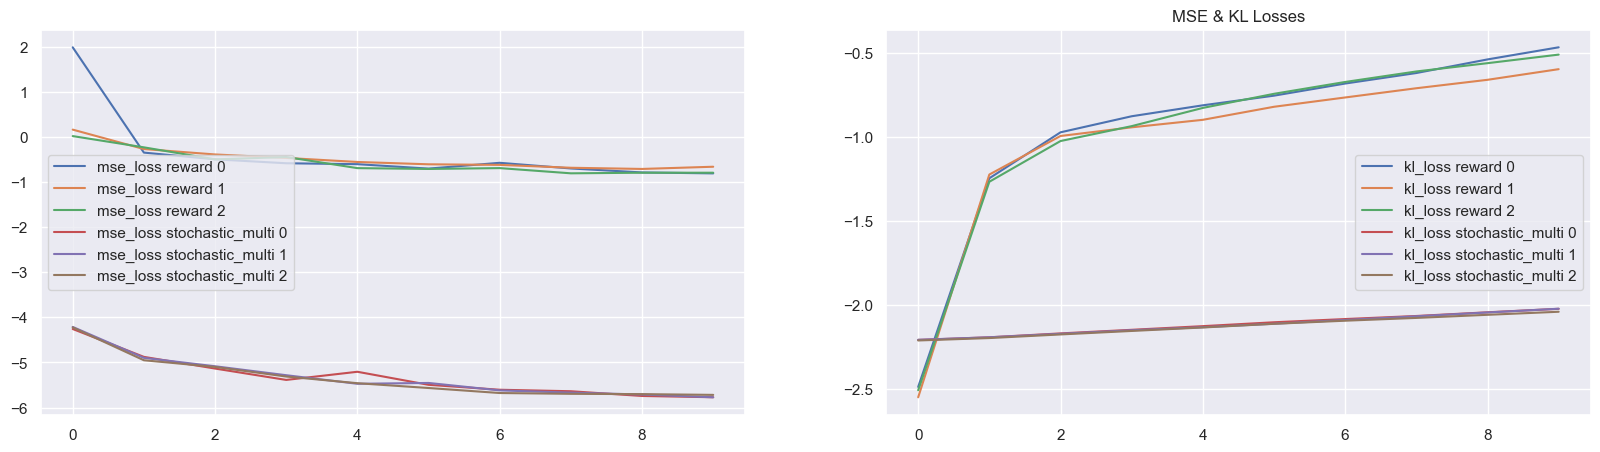

- MSE : 0.488203, KL : 0.664483
- MSE : 0.585694, KL : 0.582073
- MSE : 0.431753, KL : 0.634031


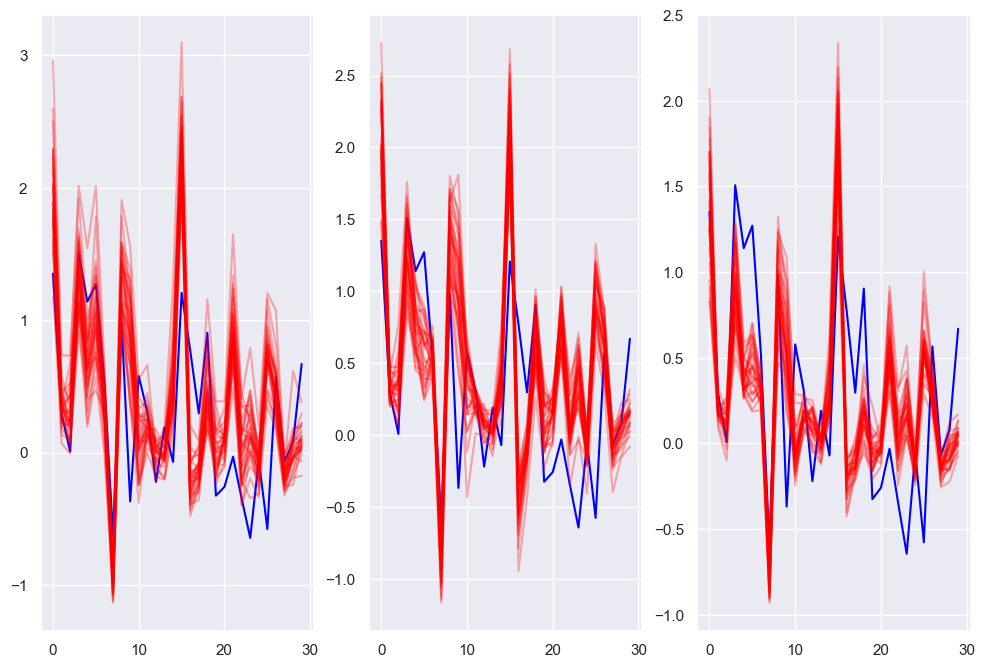

- MSE : 0.003159, KL : 0.134877
- MSE : 0.003083, KL : 0.135043
- MSE : 0.003417, KL : 0.132578


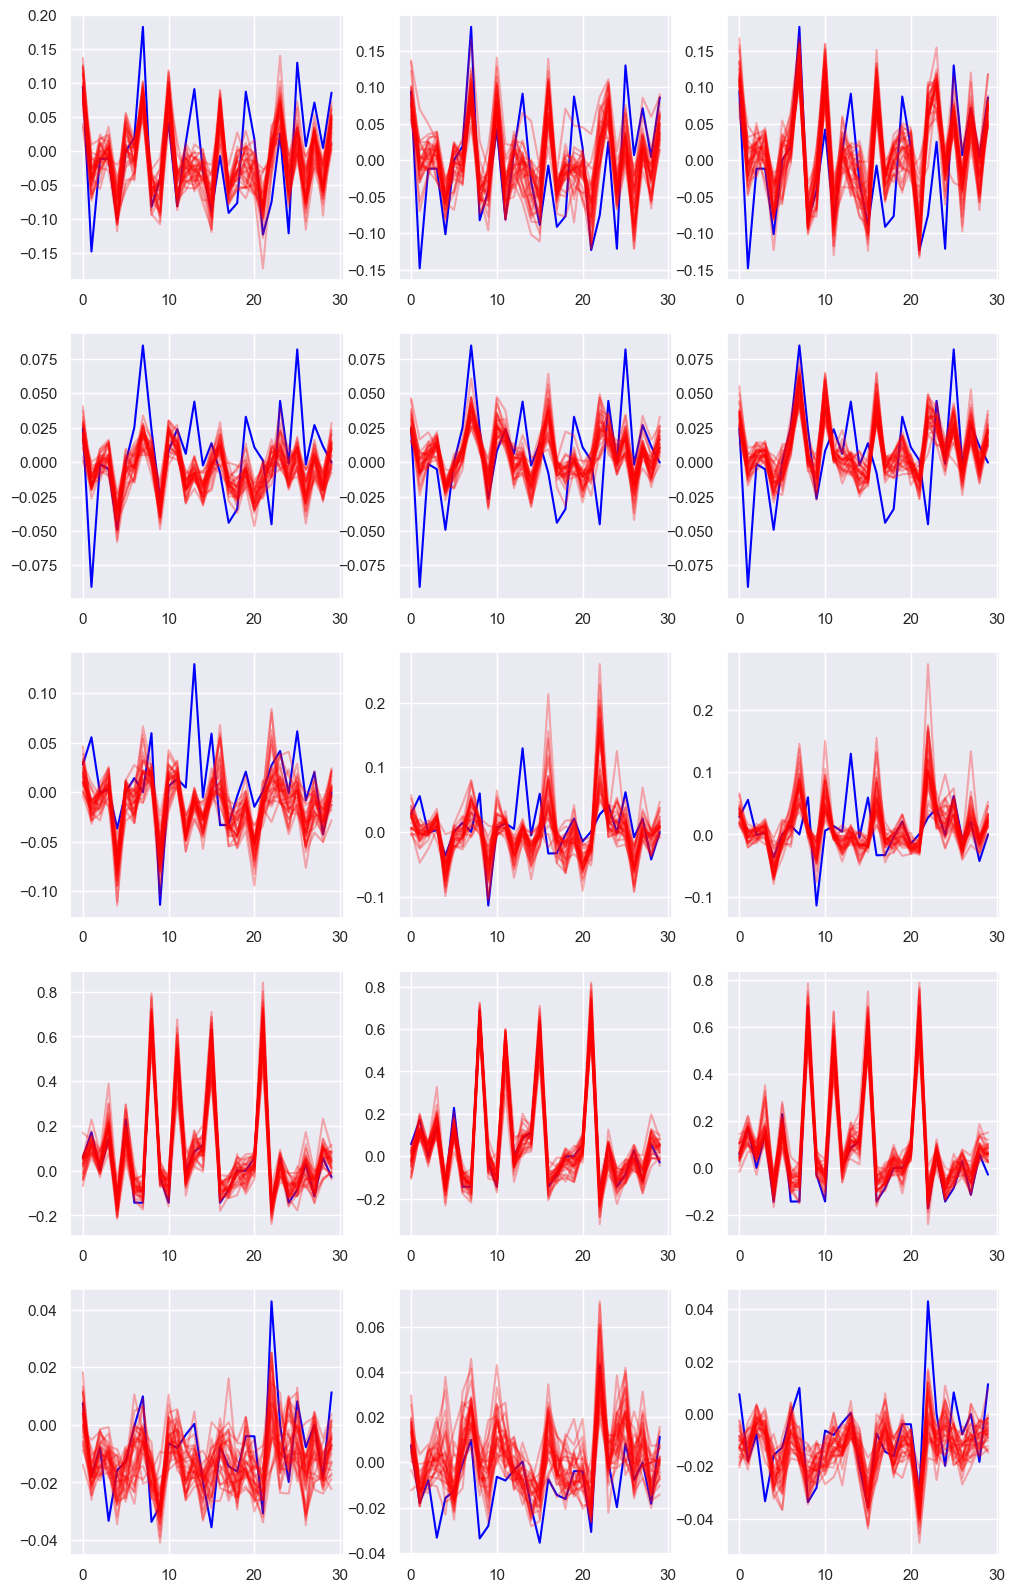

In [11]:
from models.advanced.model_utilities import plot_validation_fit
import torch.nn as nn
dynamics_model_batch_size = 256
num_dynamics_model_training_steps = 10

batch_size = 128
buffer_size = 50000
num_crops = 24
num_input_dimensions = 34+8*num_crops

# generate input indices:
input_action_idxs = list(range(num_crops))
input_condition_idxs = [24,25,26,27,28,29,30] + list(range(34+3*num_crops,34+8*num_crops))
input_prices_and_costs_idxs = [31,32,33] + list(range(34,34+3*num_crops))


# generate target indices:
target_reward_idx = 0
target_stochastic_multi_idxs = [1,2,3,4,7]
target_static_idxs = [5,6] + list(range(11+3*num_crops,11+8*num_crops))
target_prices_and_costs_idxs = [8,9,10] + list(range(11,11+3*num_crops))


custom_model_setting_dict = {    
    "stochastic_multi": {
        "type": "stochastic",
        "input_size": len(input_action_idxs + input_condition_idxs),
        "output_size": len(target_stochastic_multi_idxs),
        "num_hidden_units": 933,
        "num_hidden_layers": 3,
        "activation": nn.ReLU(),
        "input_idxs": input_action_idxs + input_condition_idxs,
        "target_idxs": target_stochastic_multi_idxs,
        "lr": 0.00089,
        "weight_decay": 9.18e-08,
        "kl_weight": 0.000135,
        "num_models": 3,
        "stochastic_layer_type": "stochastic_single"
    },
    "reward": {
        "type": "stochastic",
        "input_size": num_input_dimensions,
        "output_size": 1,
        "num_hidden_units": 256,
        "num_hidden_layers": 1,
        "activation": nn.ReLU(),
        "input_idxs": list(range(num_input_dimensions)),
        "target_idxs": [0],
        "lr": 1.53e-02,
        "weight_decay": 2.8e-05,
        "kl_weight": 0.0066,
        "num_models": 3,
        "stochastic_layer_type": "stochastic_single"
    }
}


fake_env = FakeEnv(device = device, seed = seed, custom_model_setting_dict=custom_model_setting_dict)
num_dynamics_models = fake_env.get_num_models()
dynamics_model_keys = fake_env.get_model_keys()
dynamics_all_mean_mse_losses = {}
dynamics_all_mean_kl_losses = {}
for model_key in dynamics_model_keys:
    dynamics_all_mean_mse_losses[model_key] = []
    dynamics_all_mean_kl_losses[model_key] = []

for i in range(100):
    print("Episode",i)
    fake_env.train(
        replay_buffer = experience_replay_buffer, 
        num_steps = min(int(experience_replay_buffer.buffer_length/dynamics_model_batch_size)+1, num_dynamics_model_training_steps), 
        batch_size = min(experience_replay_buffer.buffer_length, dynamics_model_batch_size)
    )
    if i%10 == 0:
        dynamics_mean_mse_losses, dynamics_mean_kl_losses = fake_env.eval(test_inputs, test_outputs)
        for model_key in dynamics_model_keys:
            dynamics_all_mean_mse_losses[model_key].append(np.log(dynamics_mean_mse_losses[model_key]))
            dynamics_all_mean_kl_losses[model_key].append(np.log(dynamics_mean_kl_losses[model_key]))

plot_mse_and_kl_losses_per_key(dynamics_all_mean_mse_losses, dynamics_all_mean_kl_losses)
plot_validation_fit(fake_env.model_loss_optimizer_pool, test_inputs, test_outputs, plot_range = 30)

# Train Single Model

In [ ]:
from models.advanced.model_utilities import plot_validation_fit_single_model

model_key = "reward"
model_idx = 0
dynamics_model_batch_size = 256
num_dynamics_model_training_steps = 10


fake_env = FakeEnv(device = device, seed = seed)
dynamics_all_mean_mse_losses = {}
dynamics_all_mean_kl_losses = {}
dynamics_all_mean_mse_losses[model_key] = []
dynamics_all_mean_kl_losses[model_key] = []

for i in range(100):
    fake_env.train_single(
        model_key = model_key,
        model_idx= model_idx,
        replay_buffer = experience_replay_buffer, 
        num_steps = min(int(experience_replay_buffer.buffer_length/dynamics_model_batch_size)+1, num_dynamics_model_training_steps), 
        batch_size = min(experience_replay_buffer.buffer_length, dynamics_model_batch_size)
    )
    if i%10 == 0:
        print("Episode",i)
        dynamics_mean_mse_losses, dynamics_mean_kl_losses = fake_env.eval_single_model(
            model_key = model_key,
            model_idx = model_idx,
            test_inputs = test_inputs, 
            test_outputs = test_outputs,)
        dynamics_all_mean_mse_losses[model_key].append(np.log(dynamics_mean_mse_losses[model_key]))
        dynamics_all_mean_kl_losses[model_key].append(np.log(dynamics_mean_kl_losses[model_key]))

plot_mse_and_kl_losses_per_key(dynamics_all_mean_mse_losses, dynamics_all_mean_kl_losses)
plot_validation_fit_single_model(
    fake_env.model_loss_optimizer_pool, 
    test_inputs, 
    test_outputs,
    model_key = model_key,
    model_idx = model_idx, 
    plot_range = 30)

# Train single model iteratively

Model-Utilities: Custom model setting dict loaded
Episode 0
Episode 10
Episode 20
Episode 30
Episode 40


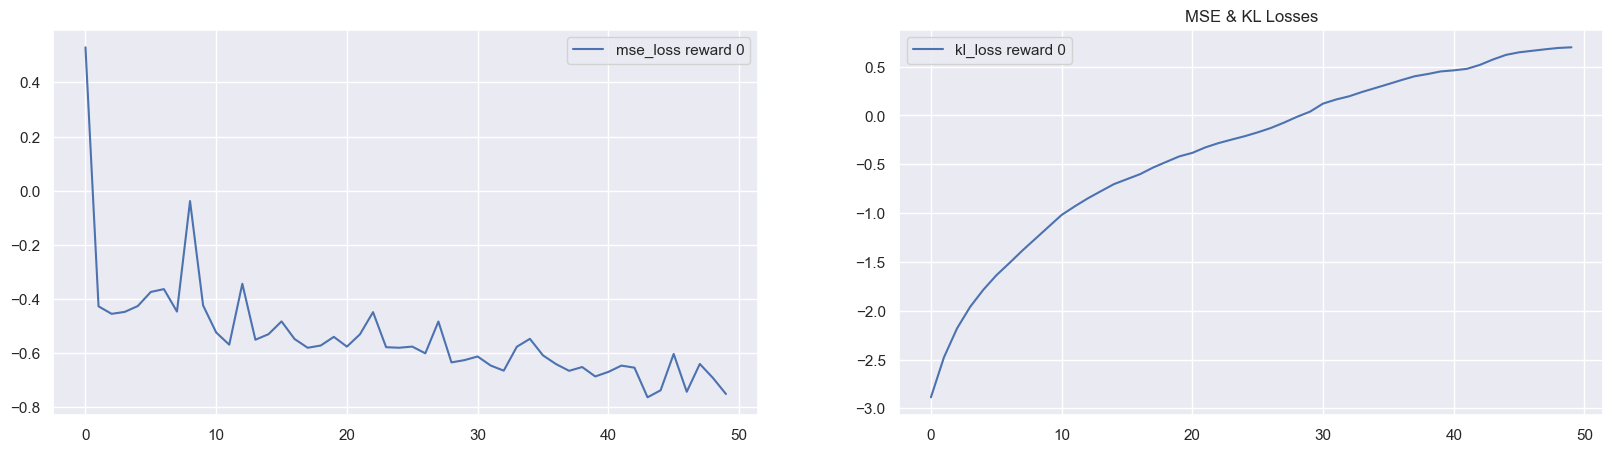

- MSE : 0.467017, KL : 2.010006


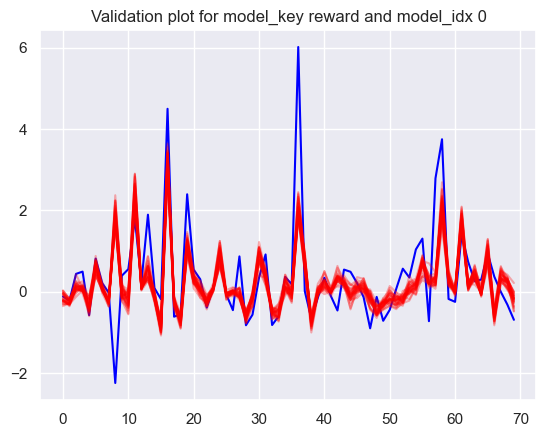

In [8]:
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
import numpy as np
from simulation_env.environment_maincrops.environment_maincrops import CropRotationEnv as CropRotationEnv_Advanced
from models.advanced.fake_env import FakeEnv
import numpy as np
from utils.experiment_utils import run_experiment, plot_experiment, plot_losses, plot_losses_sac
import torch
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
from models.advanced.model_utilities import plot_mse_and_kl_losses_per_key, plot_validation_fit_single_model
import torch.nn as nn

batch_size = 128
buffer_size = 50000
num_crops = 24
num_input_dimensions = 34+8*num_crops

# generate input indices:
input_action_idxs = list(range(num_crops))
input_condition_idxs = [24,25,26,27,28,29,30] + list(range(34+3*num_crops,34+8*num_crops))
input_prices_and_costs_idxs = [31,32,33] + list(range(34,34+3*num_crops))


# generate target indices:
target_reward_idx = 0
target_stochastic_multi_idxs = [1,2,3,4,7]
target_static_idxs = [5,6] + list(range(11+3*num_crops,11+8*num_crops))
target_prices_and_costs_idxs = [8,9,10] + list(range(11,11+3*num_crops))

seed = 43
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = CropRotationEnv_Advanced(
    seq_len = 10, 
    seed = seed, 
    DryWetInit = None, 
    GroundTypeInit = None, 
    deterministic = False
    )
reward_factor = 5.0/(env.max_reward-env.min_reward)


random_state = np.random.RandomState(seed)
experience_replay_buffer = UniformReplayBuffer(batch_size = batch_size,
                                    buffer_size = buffer_size,
                                    random_state=random_state)

model_key = "reward"
model_idx = 0
dynamics_model_batch_size = 256
num_dynamics_model_training_steps = 25

custom_model_setting_dict = {    
    "stochastic_multi": {
        "type": "stochastic",
        "input_size": len(input_action_idxs + input_condition_idxs),
        "output_size": len(target_stochastic_multi_idxs),
        "num_hidden_units": 933,
        "num_hidden_layers": 3,
        "activation": nn.ReLU(),
        "input_idxs": input_action_idxs + input_condition_idxs,
        "target_idxs": target_stochastic_multi_idxs,
        "lr": 0.00089,
        "weight_decay": 9.18e-08,
        "kl_weight": 0.000135,
        "num_models": 3,
        "stochastic_layer_type": "stochastic_single"
    },
    "reward": {
        "type": "stochastic",
        "input_size": num_input_dimensions,
        "output_size": 1,
        "num_hidden_units": 256,
        "num_hidden_layers": 1,
        "activation": nn.ReLU(),
        "input_idxs": list(range(num_input_dimensions)),
        "target_idxs": [0],
        "lr": 1.53e-02,
        "weight_decay": 2.8e-05,
        "kl_weight": 0.0066,
        "num_models": 3,
        "stochastic_layer_type": "stochastic_single"
    }
}




fake_env = FakeEnv(device = device, seed = seed, custom_model_setting_dict=custom_model_setting_dict)
dynamics_all_mean_mse_losses = {}
dynamics_all_mean_kl_losses = {}
dynamics_all_mean_mse_losses[model_key] = []
dynamics_all_mean_kl_losses[model_key] = []

for i in range(50):
    if i%10 == 0:   
        print("Episode",i)
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, _, reward, done, _ = env.step(action)
        if done:
            break
        if next_state is None:
            print("next_state is None")

        reward_tensor = torch.tensor([reward], device=device)*reward_factor
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        action_tensor = torch.tensor([action]).to(device)
        experience = Experience(state, action_tensor.view(1,1), reward_tensor.view(1,1), next_state_tensor, torch.tensor([done]).view(1,1))
        # print("Stats:", replay_buffer.buffer_size, replay_buffer.batch_size, replay_buffer._buffer_length, replay_buffer._current_idx)
        experience_replay_buffer.add(experience)
        state = next_state_tensor

        fake_env.train_single(
            model_key = model_key,
            model_idx= model_idx,
            replay_buffer = experience_replay_buffer, 
            num_steps = min(int(experience_replay_buffer.buffer_length/dynamics_model_batch_size)+1, num_dynamics_model_training_steps), 
            batch_size = min(experience_replay_buffer.buffer_length, dynamics_model_batch_size)
        )

    dynamics_mean_mse_losses, dynamics_mean_kl_losses = fake_env.eval_single_model(
        model_key = model_key,
        model_idx = model_idx,
        test_inputs = test_inputs, 
        test_outputs = test_outputs,)
    dynamics_all_mean_mse_losses[model_key].append(np.log(dynamics_mean_mse_losses[model_key]))
    dynamics_all_mean_kl_losses[model_key].append(np.log(dynamics_mean_kl_losses[model_key]))

plot_mse_and_kl_losses_per_key(dynamics_all_mean_mse_losses, dynamics_all_mean_kl_losses)
plot_validation_fit_single_model(
    fake_env.model_loss_optimizer_pool, 
    test_inputs, 
    test_outputs,
    model_key = model_key,
    model_idx = model_idx, 
    plot_range = 70)

# Optuna study for models

In [9]:
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
import numpy as np
from simulation_env.environment_maincrops.environment_maincrops import CropRotationEnv as CropRotationEnv_Advanced
from models.advanced.fake_env import FakeEnv
import numpy as np
from utils.experiment_utils import run_experiment, plot_experiment, plot_losses, plot_losses_sac
import torch
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
from models.advanced.model_utilities import plot_mse_and_kl_losses_per_key, plot_validation_fit_single_model
import optuna
import torch.nn as nn

# Create pprinter
pp = pprint.PrettyPrinter(indent=4)

seed = 42
batch_size = 128
buffer_size = 50000
num_crops = 24
num_input_dimensions = 34+8*num_crops

# generate input indices:
input_action_idxs = list(range(num_crops))
input_condition_idxs = [24,25,26,27,28,29,30] + list(range(34+3*num_crops,34+8*num_crops))
input_prices_and_costs_idxs = [31,32,33] + list(range(34,34+3*num_crops))


# generate target indices:
target_reward_idx = 0
target_stochastic_multi_idxs = [1,2,3,4,7]
target_static_idxs = [5,6] + list(range(11+3*num_crops,11+8*num_crops))
target_prices_and_costs_idxs = [8,9,10] + list(range(11,11+3*num_crops))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

reward_factor = 5.0/(env.max_reward-env.min_reward)

def objective(
        trial, 
        model_key,
        num_episodes):
    if model_key == "reward":
        custom_model_setting_dict = {
            "reward": {
                "type": "stochastic",
                "input_size": num_input_dimensions,
                "output_size": 1,
                "num_hidden_units": trial.suggest_int("num_hidden_units", 16, 1024),
                "num_hidden_layers": trial.suggest_int("num_hidden_layers", 1, 3),
                "activation": nn.ReLU(),
                "input_idxs": list(range(num_input_dimensions)),
                "target_idxs": [0],
                "lr": trial.suggest_float("lr", 1e-7, 1e-1, log=True),
                "weight_decay": trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True),
                "kl_weight": trial.suggest_float("kl_weight", 1e-5, 1e-1, log=True),
                "num_models": 1,
                "stochastic_layer_type": "stochastic_single"
            }}
    elif model_key == "stochastic_multi":
        custom_model_setting_dict = {
            "stochastic_multi": {
                "type": "stochastic",
                "input_size": len(input_action_idxs + input_condition_idxs),
                "output_size": len(target_stochastic_multi_idxs),
                "num_hidden_units": trial.suggest_int("num_hidden_units", 16, 1024),
                "num_hidden_layers": trial.suggest_int("num_hidden_layers", 1, 3),
                "activation": nn.ReLU(),
                "input_idxs": input_action_idxs + input_condition_idxs,
                "target_idxs": target_stochastic_multi_idxs,
                "lr": trial.suggest_float("lr", 1e-7, 1e-1, log=True),
                "weight_decay": trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True),
                "kl_weight": trial.suggest_float("kl_weight", 1e-5, 1e-1, log=True),
                "num_models": 1,
                "stochastic_layer_type": "stochastic_single"
            }
        }


    random_state = np.random.RandomState(seed)
    experience_replay_buffer = UniformReplayBuffer(batch_size = batch_size,
                                        buffer_size = buffer_size,
                                        random_state=random_state)
    env = CropRotationEnv_Advanced(
        seq_len = 10, 
        seed = seed, 
        DryWetInit = None, 
        GroundTypeInit = None, 
        deterministic = False
        )

    model_idx = 0
    dynamics_model_batch_size = trial.suggest_int("batch_size", 64, 512)
    num_dynamics_model_training_steps = trial.suggest_int("num_dynamics_model_training_steps", 1, 30)

    fake_env = FakeEnv(device = device, seed = seed, custom_model_setting_dict=custom_model_setting_dict)
    dynamics_all_mean_mse_losses = {}
    dynamics_all_mean_kl_losses = {}
    dynamics_all_mean_mse_losses[model_key] = []
    dynamics_all_mean_kl_losses[model_key] = []

    for i in range(num_episodes):
        # if i%10 == 0:   
        #     print("Episode",i)
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        done = False
        while not done:
            action = env.action_space.sample()
            next_state, _, reward, done, _ = env.step(action)
            if done:
                break
            if next_state is None:
                print("next_state is None")

            reward_tensor = torch.tensor([reward], device=device)*reward_factor
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            action_tensor = torch.tensor([action]).to(device)
            experience = Experience(state, action_tensor.view(1,1), reward_tensor.view(1,1), next_state_tensor, torch.tensor([done]).view(1,1))
            # print("Stats:", replay_buffer.buffer_size, replay_buffer.batch_size, replay_buffer._buffer_length, replay_buffer._current_idx)
            experience_replay_buffer.add(experience)
            state = next_state_tensor
            fake_env.train_single(
                model_key = model_key,
                model_idx= model_idx,
                replay_buffer = experience_replay_buffer, 
                num_steps = min(int(experience_replay_buffer.buffer_length/dynamics_model_batch_size)+1, num_dynamics_model_training_steps), 
                batch_size = min(experience_replay_buffer.buffer_length, dynamics_model_batch_size)
            )

        dynamics_mean_mse_losses, dynamics_mean_kl_losses = fake_env.eval_single_model(
            model_key = model_key,
            model_idx = model_idx,
            test_inputs = test_inputs, 
            test_outputs = test_outputs,)
        dynamics_all_mean_mse_losses[model_key].append(np.log(dynamics_mean_mse_losses[model_key]))
        dynamics_all_mean_kl_losses[model_key].append(np.log(dynamics_mean_kl_losses[model_key]))
    return np.mean(dynamics_mean_mse_losses[model_key][-20:]), np.mean(dynamics_mean_kl_losses[model_key][-20:])
    

def run_optuna_study(
        model_key,
        num_episodes,
        n_trials=2,
        timeout=600,):
    study = optuna.create_study(directions=["minimize","minimize"])
    objective_partial = lambda trial: objective(
                                        trial,  
                                        model_key = model_key,
                                        num_episodes = num_episodes)
    study.optimize(
        objective_partial, 
        n_trials=n_trials, 
        timeout=timeout)
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print(f"Number of trials on the Pareto front: {len(study.best_trials)}")
    trial_with_lowest_mse = min(study.best_trials, key=lambda t: t.values[0])
    print("Trial with lowest MSE:")
    print("################################")
    print(f"\tnumber: {trial_with_lowest_mse.number}")
    print("  Values: ", trial_with_lowest_mse.values)
    print(f"\tparams:")
    pp.pprint(trial_with_lowest_mse.params)

    print("All best trials on pareto front:")
    print("################################")
    for best_trial in study.best_trials:
        print(f"\tTrial number: {best_trial.number}")
        print(f"\tvalues: {best_trial.values}")
        print(f"\tparams:")
        pp.pprint(best_trial.params)
    return study

study = run_optuna_study(
    model_key = "reward",
    num_episodes = 50,
    n_trials=100,
    timeout=3600,
    )


[I 2023-11-15 12:02:33,957] A new study created in memory with name: no-name-0f74d6d7-cc28-4b97-a90e-8bfbecc8087e


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:02:45,083] Trial 0 finished with values: [0.5795746758736511, 0.07260264456272125] and parameters: {'num_hidden_units': 740, 'num_hidden_layers': 3, 'lr': 2.3814231671593946e-05, 'weight_decay': 0.00020001177102847595, 'kl_weight': 0.009865411569558996, 'batch_size': 404, 'num_dynamics_model_training_steps': 25}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:02:53,252] Trial 1 finished with values: [0.46096012997112973, 1.4104079008102417] and parameters: {'num_hidden_units': 478, 'num_hidden_layers': 2, 'lr': 0.006690166621133621, 'weight_decay': 1.4440724026933443e-05, 'kl_weight': 0.002150145830202539, 'batch_size': 112, 'num_dynamics_model_training_steps': 6}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:02:57,516] Trial 2 finished with values: [0.5836794654485461, 2.914851427078247] and parameters: {'num_hidden_units': 56, 'num_hidden_layers': 2, 'lr': 0.006566295500164762, 'weight_decay': 1.2898127757893633e-07, 'kl_weight': 3.585490952697683e-05, 'batch_size': 285, 'num_dynamics_model_training_steps': 6}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:03:06,594] Trial 3 finished with values: [0.618744281186051, 0.12392644584178925] and parameters: {'num_hidden_units': 312, 'num_hidden_layers': 1, 'lr': 0.00023426654530592312, 'weight_decay': 6.880358268610437e-10, 'kl_weight': 0.007053204234782788, 'batch_size': 72, 'num_dynamics_model_training_steps': 6}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:03:10,652] Trial 4 finished with values: [0.6731227651595082, 0.07388094067573547] and parameters: {'num_hidden_units': 261, 'num_hidden_layers': 1, 'lr': 4.3217617263055545e-07, 'weight_decay': 2.9267371149537935e-10, 'kl_weight': 2.9912305842102238e-05, 'batch_size': 393, 'num_dynamics_model_training_steps': 15}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:03:17,045] Trial 5 finished with values: [0.679695376533406, 0.07379332184791565] and parameters: {'num_hidden_units': 461, 'num_hidden_layers': 2, 'lr': 1.0961434494083148e-07, 'weight_decay': 1.605177906291012e-09, 'kl_weight': 0.001941974374110058, 'batch_size': 154, 'num_dynamics_model_training_steps': 7}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:03:21,421] Trial 6 finished with values: [0.6803111605003601, 0.07340794056653976] and parameters: {'num_hidden_units': 189, 'num_hidden_layers': 1, 'lr': 4.269641164504937e-06, 'weight_decay': 1.151134914984299e-06, 'kl_weight': 0.0005494238903106493, 'batch_size': 252, 'num_dynamics_model_training_steps': 8}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:03:25,481] Trial 7 finished with values: [0.6319944167012285, 1.0733978748321533] and parameters: {'num_hidden_units': 187, 'num_hidden_layers': 2, 'lr': 0.0053782389889051995, 'weight_decay': 3.927729928395998e-07, 'kl_weight': 0.0001572888257540842, 'batch_size': 470, 'num_dynamics_model_training_steps': 13}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:03:41,558] Trial 8 finished with values: [0.8142878599382761, 4.266020774841309] and parameters: {'num_hidden_units': 920, 'num_hidden_layers': 3, 'lr': 0.05154015688700008, 'weight_decay': 5.0975453911149014e-08, 'kl_weight': 2.1701111554439105e-05, 'batch_size': 254, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:03:50,076] Trial 9 finished with values: [0.6476653017404743, 0.07387222349643707] and parameters: {'num_hidden_units': 662, 'num_hidden_layers': 2, 'lr': 2.612550835170295e-07, 'weight_decay': 4.7017586880571445e-07, 'kl_weight': 0.028690662904851554, 'batch_size': 122, 'num_dynamics_model_training_steps': 10}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:03:53,691] Trial 10 finished with values: [0.6434543254364659, 0.0718243345618248] and parameters: {'num_hidden_units': 232, 'num_hidden_layers': 1, 'lr': 5.64260421371733e-05, 'weight_decay': 0.0005272095508138337, 'kl_weight': 0.002614729521246045, 'batch_size': 496, 'num_dynamics_model_training_steps': 11}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:04:12,650] Trial 11 finished with values: [0.662063256089829, 0.652036190032959] and parameters: {'num_hidden_units': 930, 'num_hidden_layers': 3, 'lr': 0.0029812383669934168, 'weight_decay': 2.8321625868932813e-05, 'kl_weight': 0.005041089445544987, 'batch_size': 70, 'num_dynamics_model_training_steps': 20}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:04:16,096] Trial 12 finished with values: [0.6204411009871912, 0.07332395762205124] and parameters: {'num_hidden_units': 103, 'num_hidden_layers': 1, 'lr': 0.00010922774090206091, 'weight_decay': 4.284812589531089e-08, 'kl_weight': 0.0007942925631675319, 'batch_size': 413, 'num_dynamics_model_training_steps': 19}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:04:20,692] Trial 13 finished with values: [0.5823313191790398, 8.416937828063965] and parameters: {'num_hidden_units': 138, 'num_hidden_layers': 1, 'lr': 0.046618169776343636, 'weight_decay': 3.5706561848270276e-08, 'kl_weight': 0.0009722148001855381, 'batch_size': 206, 'num_dynamics_model_training_steps': 8}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:04:24,805] Trial 14 finished with values: [0.5379668426905533, 2.316640615463257] and parameters: {'num_hidden_units': 675, 'num_hidden_layers': 1, 'lr': 0.026881409074329676, 'weight_decay': 2.266384332287058e-08, 'kl_weight': 2.6611709372953105e-05, 'batch_size': 443, 'num_dynamics_model_training_steps': 6}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:04:29,603] Trial 15 finished with values: [0.5985599863782389, 0.07274921238422394] and parameters: {'num_hidden_units': 596, 'num_hidden_layers': 1, 'lr': 3.116045232561628e-05, 'weight_decay': 1.4654368551818536e-08, 'kl_weight': 0.015160243577863263, 'batch_size': 213, 'num_dynamics_model_training_steps': 28}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:04:34,843] Trial 16 finished with values: [0.5780847924187328, 0.07639917731285095] and parameters: {'num_hidden_units': 778, 'num_hidden_layers': 1, 'lr': 8.24641116685212e-05, 'weight_decay': 1.9689555493881107e-07, 'kl_weight': 0.001288207694580938, 'batch_size': 184, 'num_dynamics_model_training_steps': 30}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:04:40,403] Trial 17 finished with values: [0.513503690906951, 1.6877857446670532] and parameters: {'num_hidden_units': 323, 'num_hidden_layers': 2, 'lr': 0.007110212526666321, 'weight_decay': 2.1995807822654174e-06, 'kl_weight': 0.00012719272145060267, 'batch_size': 242, 'num_dynamics_model_training_steps': 21}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:04:45,569] Trial 18 finished with values: [0.6564518806055007, 0.07380538433790207] and parameters: {'num_hidden_units': 426, 'num_hidden_layers': 2, 'lr': 6.309958342831282e-07, 'weight_decay': 8.838173730907651e-10, 'kl_weight': 2.716114381113483e-05, 'batch_size': 344, 'num_dynamics_model_training_steps': 12}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:04:49,460] Trial 19 finished with values: [0.6503868419885601, 0.07279785722494125] and parameters: {'num_hidden_units': 19, 'num_hidden_layers': 2, 'lr': 2.700953754078951e-05, 'weight_decay': 1.9343506648248046e-10, 'kl_weight': 1.562319023239738e-05, 'batch_size': 371, 'num_dynamics_model_training_steps': 11}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:05:00,538] Trial 20 finished with values: [0.49339304613882196, 0.09341727942228317] and parameters: {'num_hidden_units': 934, 'num_hidden_layers': 2, 'lr': 0.00025628479328463445, 'weight_decay': 6.512687975611229e-05, 'kl_weight': 7.725747465257031e-05, 'batch_size': 123, 'num_dynamics_model_training_steps': 11}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:05:09,645] Trial 21 finished with values: [0.6452042673458623, 0.07379043847322464] and parameters: {'num_hidden_units': 505, 'num_hidden_layers': 3, 'lr': 8.760442438715179e-07, 'weight_decay': 6.997608954503274e-09, 'kl_weight': 5.142640226136367e-05, 'batch_size': 116, 'num_dynamics_model_training_steps': 28}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:05:14,582] Trial 22 finished with values: [0.5543338969584529, 2.112217903137207] and parameters: {'num_hidden_units': 620, 'num_hidden_layers': 1, 'lr': 0.03454238855390364, 'weight_decay': 0.0001049524031806698, 'kl_weight': 0.008219173815900541, 'batch_size': 214, 'num_dynamics_model_training_steps': 21}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:05:18,970] Trial 23 finished with values: [0.6095824869144086, 0.14418357610702515] and parameters: {'num_hidden_units': 869, 'num_hidden_layers': 1, 'lr': 0.001589413659084865, 'weight_decay': 6.470452710571401e-08, 'kl_weight': 0.0016484373684648526, 'batch_size': 383, 'num_dynamics_model_training_steps': 12}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:05:22,845] Trial 24 finished with values: [0.5770305530175479, 0.08461988717317581] and parameters: {'num_hidden_units': 55, 'num_hidden_layers': 2, 'lr': 0.0001295487024791955, 'weight_decay': 7.512135962056572e-10, 'kl_weight': 1.282879363310281e-05, 'batch_size': 376, 'num_dynamics_model_training_steps': 30}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:05:27,073] Trial 25 finished with values: [0.6423508526992436, 0.10577205568552017] and parameters: {'num_hidden_units': 216, 'num_hidden_layers': 2, 'lr': 0.00047309531191702187, 'weight_decay': 3.339837064920217e-07, 'kl_weight': 0.021100419284312395, 'batch_size': 397, 'num_dynamics_model_training_steps': 8}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:05:32,010] Trial 26 finished with values: [0.44666863302443555, 0.32993337512016296] and parameters: {'num_hidden_units': 290, 'num_hidden_layers': 2, 'lr': 0.00238783579291189, 'weight_decay': 1.0823138394227972e-07, 'kl_weight': 0.008919311109167953, 'batch_size': 317, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:05:36,309] Trial 27 finished with values: [0.5392584528225012, 0.484213650226593] and parameters: {'num_hidden_units': 185, 'num_hidden_layers': 2, 'lr': 0.002751314994106349, 'weight_decay': 9.316342945348408e-08, 'kl_weight': 0.0018670189022535254, 'batch_size': 349, 'num_dynamics_model_training_steps': 22}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:05:43,440] Trial 28 finished with values: [0.6646231751213698, 0.07339178025722504] and parameters: {'num_hidden_units': 514, 'num_hidden_layers': 3, 'lr': 8.86113545434612e-06, 'weight_decay': 6.540159317858997e-08, 'kl_weight': 0.00030705856445825507, 'batch_size': 478, 'num_dynamics_model_training_steps': 6}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:05:51,244] Trial 29 finished with values: [0.6047764650953935, 0.07279922813177109] and parameters: {'num_hidden_units': 740, 'num_hidden_layers': 2, 'lr': 2.083854688315875e-05, 'weight_decay': 6.945037116745176e-10, 'kl_weight': 0.0014415619604611681, 'batch_size': 389, 'num_dynamics_model_training_steps': 25}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:06:01,840] Trial 30 finished with values: [0.6204137247907432, 0.07205836474895477] and parameters: {'num_hidden_units': 731, 'num_hidden_layers': 3, 'lr': 1.478325375563548e-05, 'weight_decay': 8.343900242007112e-09, 'kl_weight': 0.07577974883209836, 'batch_size': 413, 'num_dynamics_model_training_steps': 3}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:06:10,326] Trial 31 finished with values: [0.4412096130793687, 1.2003860473632812] and parameters: {'num_hidden_units': 611, 'num_hidden_layers': 1, 'lr': 0.0284816284140922, 'weight_decay': 1.015182539968668e-06, 'kl_weight': 0.019392049018037563, 'batch_size': 76, 'num_dynamics_model_training_steps': 12}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:06:14,835] Trial 32 finished with values: [0.5761637392610575, 3.7839291095733643] and parameters: {'num_hidden_units': 362, 'num_hidden_layers': 1, 'lr': 0.027446207732505296, 'weight_decay': 1.007615887768921e-06, 'kl_weight': 0.001477642787581898, 'batch_size': 285, 'num_dynamics_model_training_steps': 15}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:06:19,087] Trial 33 finished with values: [0.5080246689191645, 0.45848900079727173] and parameters: {'num_hidden_units': 835, 'num_hidden_layers': 1, 'lr': 0.006216524005658898, 'weight_decay': 1.3863631762433995e-07, 'kl_weight': 0.024319574439510886, 'batch_size': 511, 'num_dynamics_model_training_steps': 22}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:06:26,266] Trial 34 finished with values: [0.6617750397682542, 0.07388858497142792] and parameters: {'num_hidden_units': 734, 'num_hidden_layers': 2, 'lr': 1.4896599955240128e-07, 'weight_decay': 1.6225679112935095e-05, 'kl_weight': 0.038143710180573914, 'batch_size': 474, 'num_dynamics_model_training_steps': 12}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:06:30,343] Trial 35 finished with values: [0.6734203601753398, 5.499539852142334] and parameters: {'num_hidden_units': 656, 'num_hidden_layers': 1, 'lr': 0.09029611265688291, 'weight_decay': 9.218647134502854e-10, 'kl_weight': 0.0002803382501880789, 'batch_size': 435, 'num_dynamics_model_training_steps': 1}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:06:39,593] Trial 36 finished with values: [0.6547977112726319, 0.09684568643569946] and parameters: {'num_hidden_units': 526, 'num_hidden_layers': 1, 'lr': 0.00014644215697812553, 'weight_decay': 3.1002226419996253e-10, 'kl_weight': 0.0040152110024420234, 'batch_size': 66, 'num_dynamics_model_training_steps': 9}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:06:52,497] Trial 37 finished with values: [0.798096052194311, 1.6426105499267578] and parameters: {'num_hidden_units': 635, 'num_hidden_layers': 3, 'lr': 0.01646238333776906, 'weight_decay': 1.887147784283446e-07, 'kl_weight': 0.01746651667800667, 'batch_size': 80, 'num_dynamics_model_training_steps': 17}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:07:02,170] Trial 38 finished with values: [0.5198382281247909, 0.07287610322237015] and parameters: {'num_hidden_units': 1001, 'num_hidden_layers': 2, 'lr': 0.0004186378493430913, 'weight_decay': 1.121831318046714e-06, 'kl_weight': 0.02153691400268749, 'batch_size': 502, 'num_dynamics_model_training_steps': 19}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:07:10,331] Trial 39 finished with values: [0.44101507033001397, 2.008026599884033] and parameters: {'num_hidden_units': 222, 'num_hidden_layers': 1, 'lr': 0.015341207923464533, 'weight_decay': 2.7983692021312134e-05, 'kl_weight': 0.006661281355650924, 'batch_size': 78, 'num_dynamics_model_training_steps': 23}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:07:16,004] Trial 40 finished with values: [0.6366753547712214, 0.07368607819080353] and parameters: {'num_hidden_units': 516, 'num_hidden_layers': 2, 'lr': 1.6557921166706825e-06, 'weight_decay': 6.1496173001862295e-06, 'kl_weight': 0.001073206284110041, 'batch_size': 493, 'num_dynamics_model_training_steps': 15}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:07:22,896] Trial 41 finished with values: [0.6748786350012029, 0.07378267496824265] and parameters: {'num_hidden_units': 856, 'num_hidden_layers': 1, 'lr': 3.7841300859723215e-07, 'weight_decay': 8.010059551804273e-09, 'kl_weight': 0.009245738786062222, 'batch_size': 104, 'num_dynamics_model_training_steps': 10}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:07:27,152] Trial 42 finished with values: [0.6596199351349032, 0.07381375879049301] and parameters: {'num_hidden_units': 292, 'num_hidden_layers': 1, 'lr': 1.4782078793674897e-06, 'weight_decay': 1.3137844706102064e-09, 'kl_weight': 0.0002958246090785646, 'batch_size': 345, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:07:34,637] Trial 43 finished with values: [0.5866493211131747, 0.07498028129339218] and parameters: {'num_hidden_units': 311, 'num_hidden_layers': 2, 'lr': 2.288860520575066e-05, 'weight_decay': 3.8927423568502745e-06, 'kl_weight': 0.00021689923002595743, 'batch_size': 97, 'num_dynamics_model_training_steps': 6}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:07:40,163] Trial 44 finished with values: [0.554418689962238, 6.498647212982178] and parameters: {'num_hidden_units': 403, 'num_hidden_layers': 1, 'lr': 0.059693070733186186, 'weight_decay': 8.481308341740135e-09, 'kl_weight': 0.0007723006277377442, 'batch_size': 69, 'num_dynamics_model_training_steps': 2}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:07:44,384] Trial 45 finished with values: [0.5863866297203708, 3.716277599334717] and parameters: {'num_hidden_units': 501, 'num_hidden_layers': 1, 'lr': 0.07380021013227868, 'weight_decay': 6.59137684976324e-08, 'kl_weight': 0.030432688599233218, 'batch_size': 398, 'num_dynamics_model_training_steps': 30}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:07:50,723] Trial 46 finished with values: [0.6715909497199972, 0.07376274466514587] and parameters: {'num_hidden_units': 148, 'num_hidden_layers': 2, 'lr': 3.800336874357209e-07, 'weight_decay': 3.852470886799399e-07, 'kl_weight': 0.00017339922411357153, 'batch_size': 127, 'num_dynamics_model_training_steps': 23}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:07:55,350] Trial 47 finished with values: [0.5364627780650912, 0.2515115439891815] and parameters: {'num_hidden_units': 604, 'num_hidden_layers': 1, 'lr': 0.0022968988917378254, 'weight_decay': 1.0228073151609902e-06, 'kl_weight': 0.00039086462303697096, 'batch_size': 357, 'num_dynamics_model_training_steps': 15}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:08:07,838] Trial 48 finished with values: [0.6289508076176842, 0.07353229820728302] and parameters: {'num_hidden_units': 1008, 'num_hidden_layers': 2, 'lr': 5.088691008464968e-06, 'weight_decay': 7.064030336730171e-05, 'kl_weight': 0.0026723574191454607, 'batch_size': 112, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:08:16,248] Trial 49 finished with values: [0.6482757523137315, 11.714499473571777] and parameters: {'num_hidden_units': 154, 'num_hidden_layers': 1, 'lr': 0.0559009545174111, 'weight_decay': 2.4190119720781116e-09, 'kl_weight': 0.00013758153762226583, 'batch_size': 75, 'num_dynamics_model_training_steps': 8}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:08:23,401] Trial 50 finished with values: [0.5544631868287435, 1.0912442207336426] and parameters: {'num_hidden_units': 323, 'num_hidden_layers': 3, 'lr': 0.007110212526666321, 'weight_decay': 2.7983692021312134e-05, 'kl_weight': 0.00012719272145060267, 'batch_size': 242, 'num_dynamics_model_training_steps': 23}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:08:28,535] Trial 51 finished with values: [0.5134306248826755, 0.3713964819908142] and parameters: {'num_hidden_units': 290, 'num_hidden_layers': 2, 'lr': 0.00238783579291189, 'weight_decay': 1.0823138394227972e-07, 'kl_weight': 0.008919311109167953, 'batch_size': 317, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:08:32,841] Trial 52 finished with values: [0.5738192263948705, 0.22882501780986786] and parameters: {'num_hidden_units': 596, 'num_hidden_layers': 1, 'lr': 0.0022968988917378254, 'weight_decay': 1.0228073151609902e-06, 'kl_weight': 0.015160243577863263, 'batch_size': 357, 'num_dynamics_model_training_steps': 28}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:08:38,589] Trial 53 finished with values: [0.6148252338969253, 0.07432874292135239] and parameters: {'num_hidden_units': 449, 'num_hidden_layers': 2, 'lr': 2.700953754078951e-05, 'weight_decay': 1.6358380489530574e-05, 'kl_weight': 1.562319023239738e-05, 'batch_size': 349, 'num_dynamics_model_training_steps': 22}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:08:48,799] Trial 54 finished with values: [0.6430956823985643, 0.07382796704769135] and parameters: {'num_hidden_units': 817, 'num_hidden_layers': 2, 'lr': 3.7841300859723215e-07, 'weight_decay': 7.064030336730171e-05, 'kl_weight': 0.009245738786062222, 'batch_size': 112, 'num_dynamics_model_training_steps': 10}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:08:56,099] Trial 55 finished with values: [0.6368237272842536, 0.07348641753196716] and parameters: {'num_hidden_units': 734, 'num_hidden_layers': 2, 'lr': 5.088691008464968e-06, 'weight_decay': 1.6225679112935095e-05, 'kl_weight': 0.0026723574191454607, 'batch_size': 474, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:09:00,323] Trial 56 finished with values: [0.684021088212826, 0.07388114184141159] and parameters: {'num_hidden_units': 261, 'num_hidden_layers': 1, 'lr': 4.3217617263055545e-07, 'weight_decay': 2.5230114765878864e-07, 'kl_weight': 2.9912305842102238e-05, 'batch_size': 419, 'num_dynamics_model_training_steps': 15}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:09:06,451] Trial 57 finished with values: [0.551630954750676, 0.3277702331542969] and parameters: {'num_hidden_units': 407, 'num_hidden_layers': 2, 'lr': 0.00238783579291189, 'weight_decay': 1.0823138394227972e-07, 'kl_weight': 0.008919311109167953, 'batch_size': 317, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:09:12,458] Trial 58 finished with values: [0.6384698826225427, 0.07353799045085907] and parameters: {'num_hidden_units': 292, 'num_hidden_layers': 3, 'lr': 8.86113545434612e-06, 'weight_decay': 6.540159317858997e-08, 'kl_weight': 0.0002958246090785646, 'batch_size': 345, 'num_dynamics_model_training_steps': 6}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:09:28,804] Trial 59 finished with values: [1.1549762400600834, 2.8088862895965576] and parameters: {'num_hidden_units': 920, 'num_hidden_layers': 3, 'lr': 0.05154015688700008, 'weight_decay': 5.0975453911149014e-08, 'kl_weight': 2.1701111554439105e-05, 'batch_size': 254, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:09:35,633] Trial 60 finished with values: [0.6043374776690313, 0.08606801182031631] and parameters: {'num_hidden_units': 778, 'num_hidden_layers': 1, 'lr': 0.00014644215697812553, 'weight_decay': 2.879038015303603e-10, 'kl_weight': 0.0040152110024420234, 'batch_size': 113, 'num_dynamics_model_training_steps': 9}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:09:39,753] Trial 61 finished with values: [0.6896840973044747, 0.07384639978408813] and parameters: {'num_hidden_units': 261, 'num_hidden_layers': 1, 'lr': 4.3217617263055545e-07, 'weight_decay': 2.9267371149537935e-10, 'kl_weight': 0.024319574439510886, 'batch_size': 393, 'num_dynamics_model_training_steps': 30}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:09:45,250] Trial 62 finished with values: [0.6672886260118677, 0.07379414886236191] and parameters: {'num_hidden_units': 461, 'num_hidden_layers': 2, 'lr': 1.0961434494083148e-07, 'weight_decay': 5.9460531646053415e-08, 'kl_weight': 0.004730380366062648, 'batch_size': 376, 'num_dynamics_model_training_steps': 30}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:09:52,381] Trial 63 finished with values: [0.557717369173754, 0.2780414819717407] and parameters: {'num_hidden_units': 604, 'num_hidden_layers': 2, 'lr': 0.0022968988917378254, 'weight_decay': 1.5300355818829945e-09, 'kl_weight': 0.008919311109167953, 'batch_size': 317, 'num_dynamics_model_training_steps': 15}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:09:56,573] Trial 64 finished with values: [0.6648635709353495, 0.07375098764896393] and parameters: {'num_hidden_units': 292, 'num_hidden_layers': 1, 'lr': 2.058380084468975e-06, 'weight_decay': 0.00015093003298835794, 'kl_weight': 0.0007723006277377442, 'batch_size': 348, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:00,726] Trial 65 finished with values: [0.5211417083076844, 3.019948720932007] and parameters: {'num_hidden_units': 640, 'num_hidden_layers': 1, 'lr': 0.03454238855390364, 'weight_decay': 0.0001049524031806698, 'kl_weight': 0.0007942925631675319, 'batch_size': 413, 'num_dynamics_model_training_steps': 19}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:05,016] Trial 66 finished with values: [0.6491371922698559, 0.07272948324680328] and parameters: {'num_hidden_units': 516, 'num_hidden_layers': 1, 'lr': 1.7767970736881376e-05, 'weight_decay': 3.1002226419996253e-10, 'kl_weight': 0.0040152110024420234, 'batch_size': 493, 'num_dynamics_model_training_steps': 15}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:09,259] Trial 67 finished with values: [0.6134715804165238, 0.07079315185546875] and parameters: {'num_hidden_units': 232, 'num_hidden_layers': 2, 'lr': 5.64260421371733e-05, 'weight_decay': 2.1618856243046358e-06, 'kl_weight': 0.002614729521246045, 'batch_size': 389, 'num_dynamics_model_training_steps': 25}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:13,970] Trial 68 finished with values: [0.6180462534974129, 0.07301362603902817] and parameters: {'num_hidden_units': 328, 'num_hidden_layers': 1, 'lr': 3.116045232561628e-05, 'weight_decay': 1.4654368551818536e-08, 'kl_weight': 0.0007942925631675319, 'batch_size': 213, 'num_dynamics_model_training_steps': 19}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:23,719] Trial 69 finished with values: [0.6194403675519407, 0.07362259179353714] and parameters: {'num_hidden_units': 514, 'num_hidden_layers': 3, 'lr': 8.86113545434612e-06, 'weight_decay': 6.997608954503274e-09, 'kl_weight': 0.00030705856445825507, 'batch_size': 116, 'num_dynamics_model_training_steps': 28}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:30,123] Trial 70 finished with values: [0.6425421299496996, 0.07382811605930328] and parameters: {'num_hidden_units': 675, 'num_hidden_layers': 2, 'lr': 1.6557921166706825e-06, 'weight_decay': 6.1496173001862295e-06, 'kl_weight': 0.001073206284110041, 'batch_size': 443, 'num_dynamics_model_training_steps': 6}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:37,568] Trial 71 finished with values: [0.6125060042454761, 0.07375934720039368] and parameters: {'num_hidden_units': 699, 'num_hidden_layers': 2, 'lr': 2.700953754078951e-05, 'weight_decay': 1.9343506648248046e-10, 'kl_weight': 0.00017339922411357153, 'batch_size': 371, 'num_dynamics_model_training_steps': 11}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:41,578] Trial 72 finished with values: [0.6005204466723978, 0.082268126308918] and parameters: {'num_hidden_units': 55, 'num_hidden_layers': 2, 'lr': 0.0001295487024791955, 'weight_decay': 7.512135962056572e-10, 'kl_weight': 1.282879363310281e-05, 'batch_size': 376, 'num_dynamics_model_training_steps': 30}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:45,858] Trial 73 finished with values: [0.6078003948332529, 0.1212388426065445] and parameters: {'num_hidden_units': 216, 'num_hidden_layers': 2, 'lr': 0.00047309531191702187, 'weight_decay': 3.339837064920217e-07, 'kl_weight': 7.725747465257031e-05, 'batch_size': 397, 'num_dynamics_model_training_steps': 12}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:49,756] Trial 74 finished with values: [0.7245087287103134, 0.07391292601823807] and parameters: {'num_hidden_units': 138, 'num_hidden_layers': 2, 'lr': 1.4896599955240128e-07, 'weight_decay': 3.5706561848270276e-08, 'kl_weight': 0.0009722148001855381, 'batch_size': 448, 'num_dynamics_model_training_steps': 12}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:10:58,658] Trial 75 finished with values: [0.5690796800538629, 0.07306750863790512] and parameters: {'num_hidden_units': 738, 'num_hidden_layers': 2, 'lr': 2.3814231671593946e-05, 'weight_decay': 0.00020001177102847595, 'kl_weight': 0.009865411569558996, 'batch_size': 214, 'num_dynamics_model_training_steps': 28}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:11:02,971] Trial 76 finished with values: [0.5524006295030938, 0.383914053440094] and parameters: {'num_hidden_units': 869, 'num_hidden_layers': 1, 'lr': 0.006216524005658898, 'weight_decay': 1.3863631762433995e-07, 'kl_weight': 0.024319574439510886, 'batch_size': 511, 'num_dynamics_model_training_steps': 26}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:11:08,357] Trial 77 finished with values: [0.6577038905137911, 0.07372775673866272] and parameters: {'num_hidden_units': 261, 'num_hidden_layers': 3, 'lr': 1.52122412461762e-06, 'weight_decay': 2.9267371149537935e-10, 'kl_weight': 0.026370688239190282, 'batch_size': 446, 'num_dynamics_model_training_steps': 15}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:11:13,319] Trial 78 finished with values: [0.6008183620332661, 0.07260992377996445] and parameters: {'num_hidden_units': 869, 'num_hidden_layers': 1, 'lr': 2.083854688315875e-05, 'weight_decay': 1.4654368551818536e-08, 'kl_weight': 0.015160243577863263, 'batch_size': 213, 'num_dynamics_model_training_steps': 25}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:11:19,560] Trial 79 finished with values: [0.4615193357628857, 1.2491464614868164] and parameters: {'num_hidden_units': 611, 'num_hidden_layers': 1, 'lr': 0.015341207923464533, 'weight_decay': 1.015182539968668e-06, 'kl_weight': 0.006661281355650924, 'batch_size': 148, 'num_dynamics_model_training_steps': 12}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:11:26,084] Trial 80 finished with values: [0.5004466640024672, 0.5601425766944885] and parameters: {'num_hidden_units': 185, 'num_hidden_layers': 2, 'lr': 0.002751314994106349, 'weight_decay': 9.316342945348408e-08, 'kl_weight': 0.028690662904851554, 'batch_size': 122, 'num_dynamics_model_training_steps': 10}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:11:30,332] Trial 81 finished with values: [0.6148307977470683, 0.07129240781068802] and parameters: {'num_hidden_units': 232, 'num_hidden_layers': 1, 'lr': 5.64260421371733e-05, 'weight_decay': 0.0005272095508138337, 'kl_weight': 0.02153691400268749, 'batch_size': 496, 'num_dynamics_model_training_steps': 11}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:11:34,436] Trial 82 finished with values: [0.7426785890950421, 0.07262671738862991] and parameters: {'num_hidden_units': 19, 'num_hidden_layers': 2, 'lr': 3.074268141381958e-07, 'weight_decay': 7.512135962056572e-10, 'kl_weight': 1.282879363310281e-05, 'batch_size': 371, 'num_dynamics_model_training_steps': 11}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:11:38,983] Trial 83 finished with values: [0.508179293433981, 10.299779891967773] and parameters: {'num_hidden_units': 55, 'num_hidden_layers': 1, 'lr': 0.027446207732505296, 'weight_decay': 7.512135962056572e-10, 'kl_weight': 1.282879363310281e-05, 'batch_size': 285, 'num_dynamics_model_training_steps': 24}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:11:46,973] Trial 84 finished with values: [0.6570607449318073, 0.12963175773620605] and parameters: {'num_hidden_units': 222, 'num_hidden_layers': 1, 'lr': 0.00022009828859830894, 'weight_decay': 2.7983692021312134e-05, 'kl_weight': 0.001073206284110041, 'batch_size': 78, 'num_dynamics_model_training_steps': 23}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:11:53,915] Trial 85 finished with values: [0.4861287957587631, 1.2074636220932007] and parameters: {'num_hidden_units': 516, 'num_hidden_layers': 2, 'lr': 0.007110212526666321, 'weight_decay': 2.1995807822654174e-06, 'kl_weight': 0.00012719272145060267, 'batch_size': 242, 'num_dynamics_model_training_steps': 21}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:12:02,435] Trial 86 finished with values: [0.5895808082069712, 0.3187384009361267] and parameters: {'num_hidden_units': 505, 'num_hidden_layers': 3, 'lr': 0.00238783579291189, 'weight_decay': 1.0037005262824355e-09, 'kl_weight': 0.008919311109167953, 'batch_size': 317, 'num_dynamics_model_training_steps': 28}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:12:14,480] Trial 87 finished with values: [0.5248000376671553, 0.07358258217573166] and parameters: {'num_hidden_units': 835, 'num_hidden_layers': 3, 'lr': 0.0004186378493430913, 'weight_decay': 1.121831318046714e-06, 'kl_weight': 0.024319574439510886, 'batch_size': 511, 'num_dynamics_model_training_steps': 22}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:12:19,080] Trial 88 finished with values: [0.5500385885079087, 0.08122850954532623] and parameters: {'num_hidden_units': 292, 'num_hidden_layers': 1, 'lr': 0.00019932952763763236, 'weight_decay': 1.0823138394227972e-07, 'kl_weight': 0.008919311109167953, 'batch_size': 317, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:12:23,611] Trial 89 finished with values: [0.5776225234549677, 2.6670217514038086] and parameters: {'num_hidden_units': 604, 'num_hidden_layers': 1, 'lr': 0.0284816284140922, 'weight_decay': 1.015182539968668e-06, 'kl_weight': 0.00039086462303697096, 'batch_size': 357, 'num_dynamics_model_training_steps': 15}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:12:29,916] Trial 90 finished with values: [0.6305830551809538, 0.07327792048454285] and parameters: {'num_hidden_units': 323, 'num_hidden_layers': 2, 'lr': 2.083854688315875e-05, 'weight_decay': 2.1995807822654174e-06, 'kl_weight': 0.0014415619604611681, 'batch_size': 159, 'num_dynamics_model_training_steps': 25}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:12:35,632] Trial 91 finished with values: [0.6341776689311175, 0.07352904975414276] and parameters: {'num_hidden_units': 516, 'num_hidden_layers': 2, 'lr': 5.088691008464968e-06, 'weight_decay': 1.0550294047390967e-08, 'kl_weight': 0.001073206284110041, 'batch_size': 493, 'num_dynamics_model_training_steps': 5}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:12:45,170] Trial 92 finished with values: [0.6305659792395011, 0.12720619142055511] and parameters: {'num_hidden_units': 164, 'num_hidden_layers': 1, 'lr': 0.00014644215697812553, 'weight_decay': 3.1002226419996253e-10, 'kl_weight': 0.002614729521246045, 'batch_size': 66, 'num_dynamics_model_training_steps': 9}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:12:49,306] Trial 93 finished with values: [0.5444694363034533, 1.2594833374023438] and parameters: {'num_hidden_units': 514, 'num_hidden_layers': 1, 'lr': 0.0284816284140922, 'weight_decay': 9.521045804163338e-06, 'kl_weight': 0.019392049018037563, 'batch_size': 478, 'num_dynamics_model_training_steps': 6}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:12:58,211] Trial 94 finished with values: [0.5417738516468507, 2.5752832889556885] and parameters: {'num_hidden_units': 187, 'num_hidden_layers': 2, 'lr': 0.015341207923464533, 'weight_decay': 3.927729928395998e-07, 'kl_weight': 0.000275290124436158, 'batch_size': 78, 'num_dynamics_model_training_steps': 23}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:13:03,658] Trial 95 finished with values: [0.5698479086189305, 0.39331114292144775] and parameters: {'num_hidden_units': 290, 'num_hidden_layers': 2, 'lr': 0.00238783579291189, 'weight_decay': 1.0823138394227972e-07, 'kl_weight': 0.001477642787581898, 'batch_size': 317, 'num_dynamics_model_training_steps': 13}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:13:12,027] Trial 96 finished with values: [0.6533587552960686, 0.07387956231832504] and parameters: {'num_hidden_units': 662, 'num_hidden_layers': 2, 'lr': 2.612550835170295e-07, 'weight_decay': 4.7017586880571445e-07, 'kl_weight': 0.002614729521246045, 'batch_size': 147, 'num_dynamics_model_training_steps': 11}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:13:17,169] Trial 97 finished with values: [0.6827864936888711, 0.0737513080239296] and parameters: {'num_hidden_units': 501, 'num_hidden_layers': 1, 'lr': 6.309958342831282e-07, 'weight_decay': 3.0032274582501987e-07, 'kl_weight': 0.030432688599233218, 'batch_size': 173, 'num_dynamics_model_training_steps': 30}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:13:21,323] Trial 98 finished with values: [0.736511919194637, 0.07361269742250443] and parameters: {'num_hidden_units': 55, 'num_hidden_layers': 2, 'lr': 1.6557921166706825e-06, 'weight_decay': 7.512135962056572e-10, 'kl_weight': 0.00029138249335155646, 'batch_size': 493, 'num_dynamics_model_training_steps': 15}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-15 12:13:32,493] Trial 99 finished with values: [0.47078227377971926, 0.68974369764328] and parameters: {'num_hidden_units': 740, 'num_hidden_layers': 3, 'lr': 0.006690166621133621, 'weight_decay': 0.00020001177102847595, 'kl_weight': 0.0003983936950010892, 'batch_size': 404, 'num_dynamics_model_training_steps': 6}. 


Study statistics: 
  Number of finished trials:  100
Number of trials on the Pareto front: 7
Trial with lowest MSE:
################################
	number: 39
  Values:  [0.44101507033001397, 2.008026599884033]
	params:
{   'batch_size': 78,
    'kl_weight': 0.006661281355650924,
    'lr': 0.015341207923464533,
    'num_dynamics_model_training_steps': 23,
    'num_hidden_layers': 1,
    'num_hidden_units': 222,
    'weight_decay': 2.7983692021312134e-05}
All best trials on pareto front:
################################
	Trial number: 0
	values: [0.5795746758736511, 0.07260264456272125]
	params:
{   'batch_size': 404,
    'kl_weight': 0.009865411569558996,
    'lr': 2.3814231671593946e-05,
    'num_dynamics_model_training_steps': 25,
    'num_hidden_layers': 3,
    'num_hidden_units': 740,
    'weight_decay': 0.00020001177102847595}
	Trial number: 20
	values: [0.49339304613882196, 0.09341727942228317]
	params:
{   'batch_size': 123,
    'kl_weight': 7.725747465257031e-05,
    'lr': 0.

In [13]:
# order the dataframe by mse ascending
study.trials_dataframe().sort_values(by="values_0", ascending=True)


,number,values_0,values_1,datetime_start,datetime_complete,duration,params_batch_size,params_kl_weight,params_lr,params_num_dynamics_model_training_steps,params_num_hidden_layers,params_num_hidden_units,params_weight_decay,system_attrs_nsga2:generation,state
39,39,0.441015,2.008027,2023-11-15 12:07:02.171478,2023-11-15 12:07:10.330621,0 days 00:00:08.159143,78,0.006661,1.534121e-02,23,1,222,2.798369e-05,0,COMPLETE
31,31,0.441210,1.200386,2023-11-15 12:06:01.841905,2023-11-15 12:06:10.326124,0 days 00:00:08.484219,76,0.019392,2.848163e-02,12,1,611,1.015183e-06,0,COMPLETE
26,26,0.446669,0.329933,2023-11-15 12:05:27.074880,2023-11-15 12:05:32.010417,0 days 00:00:04.935537,317,0.008919,2.387836e-03,5,2,290,1.082314e-07,0,COMPLETE
1,1,0.460960,1.410408,2023-11-15 12:02:45.083988,2023-11-15 12:02:53.252729,0 days 00:00:08.168741,112,0.002150,6.690167e-03,6,2,478,1.444072e-05,0,COMPLETE
79,79,0.461519,1.249146,2023-11-15 12:11:13.320220,2023-11-15 12:11:19.560961,0 days 00:00:06.240741,148,0.006661,1.534121e-02,12,1,611,1.015183e-06,1,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,98,0.736512,0.073613,2023-11-15 12:13:17.170398,2023-11-15 12:13:21.322020,0 days 00:00:04.151622,493,0.000291,1.655792e-06,15,2,55,7.512136e-10,1,COMPLETE
82,82,0.742679,0.072627,2023-11-15 12:11:30.333382,2023-11-15 12:11:34.436018,0 days 00:00:04.102636,371,0.000013,3.074268e-07,11,2,19,7.512136e-10,1,COMPLETE
37,37,0.798096,1.642611,2023-11-15 12:06:39.594694,2023-11-15 12:06:52.497829,0 days 00:00:12.903135,80,0.017467,1.646238e-02,17,3,635,1.887148e-07,0,COMPLETE
8,8,0.814288,4.266021,2023-11-15 12:03:25.482981,2023-11-15 12:03:41.558398,0 days 00:00:16.075417,254,0.000022,5.154016e-02,5,3,920,5.097545e-08,0,COMPLETE
